# Package installation

In [1]:
!pip uninstall keras-core
!pip uninstall -q keras-nlp

# !pip install tensorflow-text

In [4]:
!pip install keras-core
!pip install -q keras-nlp
!pip install --upgrade tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


# Connecting to drive for Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [6]:
import os

# Specify the path to the folder
folder_path = '/content/Figures'  # Change this path as needed

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Requirements File

In [ ]:
pip freeze > requirements.txt

In [7]:
import re
from collections import defaultdict
import keras
import keras_nlp
import tensorflow as tf
# import keras_core as keras
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import feature_extraction
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [9]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.16.1
KerasNLP version: 0.9.3


# Loading the dataset and understanding

In [11]:
df__tweet_tr = pd.read_csv('/content/drive/MyDrive/train.csv', index_col=0)
# df__tweet_te = pd.read_csv('/content/drive/MyDrive/test.csv', index_col=0)


In [12]:
df__tweet_tr.head(5)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
# df__tweet_te.head(5)

# Parameter Settings Table

In [14]:
BATCH_SIZE = 20
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
NUM_TRAINING_EXAMPLES = df__tweet_tr.shape[0]
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 7
AUTO = tf.data.experimental.AUTOTUNE

np.random.seed(0)
keras.utils.set_random_seed(0)

In [15]:
# Function to display confusion matrix
def dgetConfusionMatrix(y_true, y_pred, dataset,model_name):
    colors = ['#FFFFFF', '#F4BBFF', '#FFC1E0', '#A64CA6']
    try:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues

        )
        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    except Exception as e:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues

        )
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + "Dataset | F1 Score: " + str(f1_score.round(2)))
    plt.savefig('Figures/' + model_name + '_' + dataset + '_confusion_matrix.png')


# Exploratory Data Analysis

Number of words in tweets based on the class

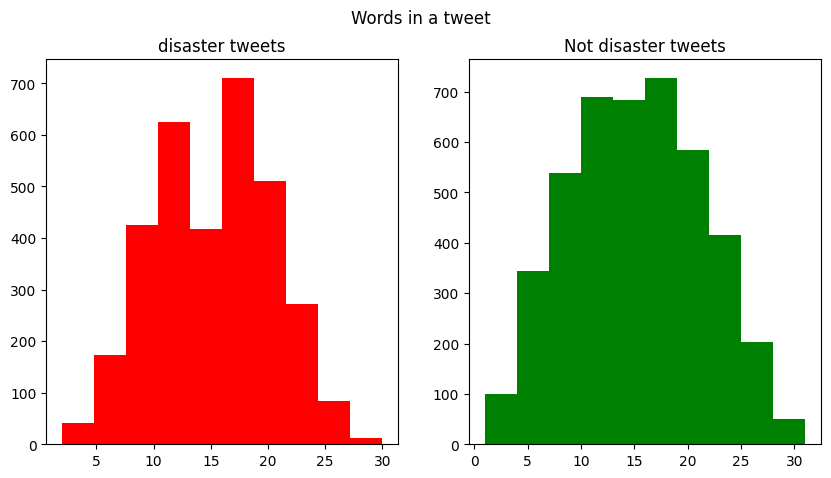

<Figure size 640x480 with 0 Axes>

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df__tweet_tr[df__tweet_tr['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df__tweet_tr[df__tweet_tr['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()
plt.savefig('Figures/number0fWords.png')

Creating the corpus for analysis of data

In [17]:
def create_tweet_corpus(tweet, target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [18]:
corpus_new = create_tweet_corpus(df__tweet_tr, 1)
len(corpus_new)

49613

Plot to display the punctuations in the tweets

In [19]:
import string
def displayPunctuations(corpus):
  dic=defaultdict(int)
  special = string.punctuation
  for i in (corpus):
    if i in special:
        dic[i]+=1

  return zip(*dic.items())


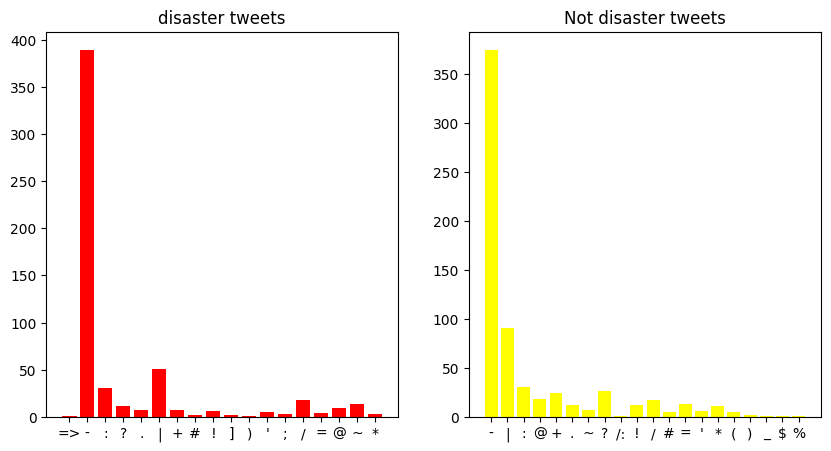

In [20]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
corpus=create_tweet_corpus(df__tweet_tr,1)
x,y =displayPunctuations(corpus)
ax1.bar(x,y,color='red')
ax1.set_title('disaster tweets')

corpus=create_tweet_corpus(df__tweet_tr,0)
x,y =displayPunctuations(corpus)
ax2.bar(x,y,color='yellow')
ax2.set_title('Not disaster tweets')
plt.savefig('Figures/punctuationfor1.png')

Analysing the most common words in the tweet

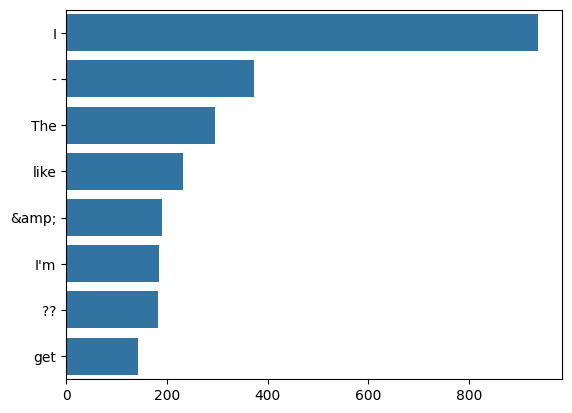

In [21]:
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.savefig('Figures/commonwords.png')


In [22]:
# df=pd.concat([df__tweet_tr,df__tweet_te])
# df.shape

Analysing the Bigrams in the tweets

In [23]:
def tweets_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

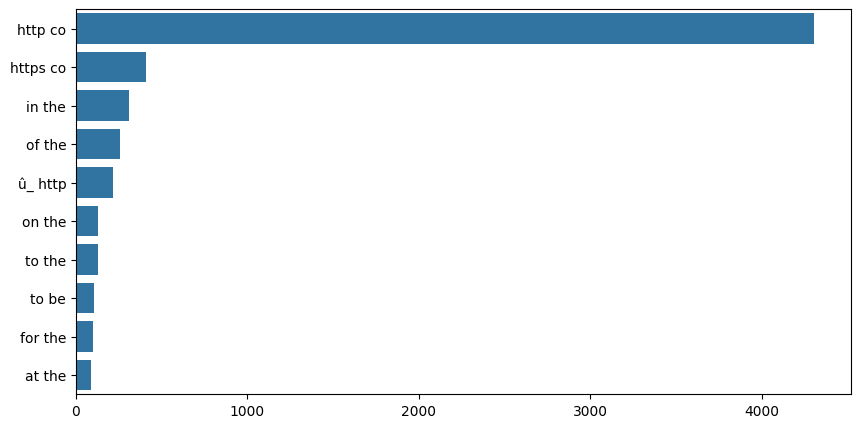

In [24]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=tweets_bigrams(df__tweet_tr['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.savefig('Figures/bigram.png')

# Data cleaning

In [25]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [26]:
df__tweet_tr['text']=df__tweet_tr['text'].apply(lambda x : remove_URL(x))

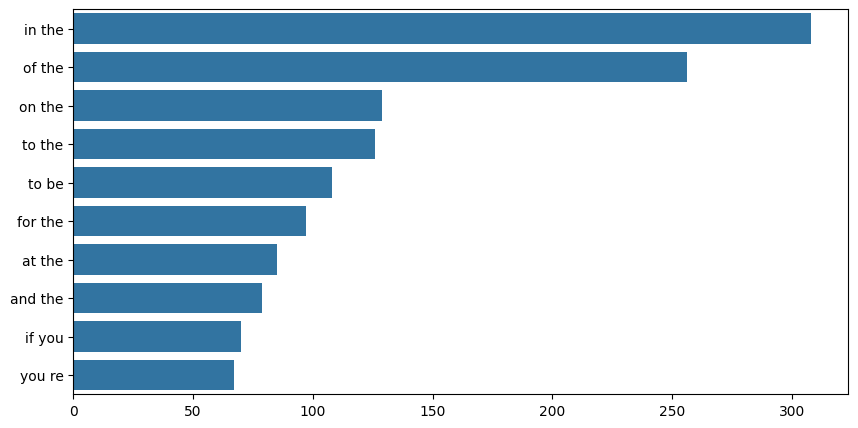

In [27]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=tweets_bigrams(df__tweet_tr['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.savefig('Figures/CleanedDatabigram.png')

In [28]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [29]:
df__tweet_tr['text']=df__tweet_tr['text'].apply(lambda x : remove_punct(x))

Words Cloud after Data Cleaning

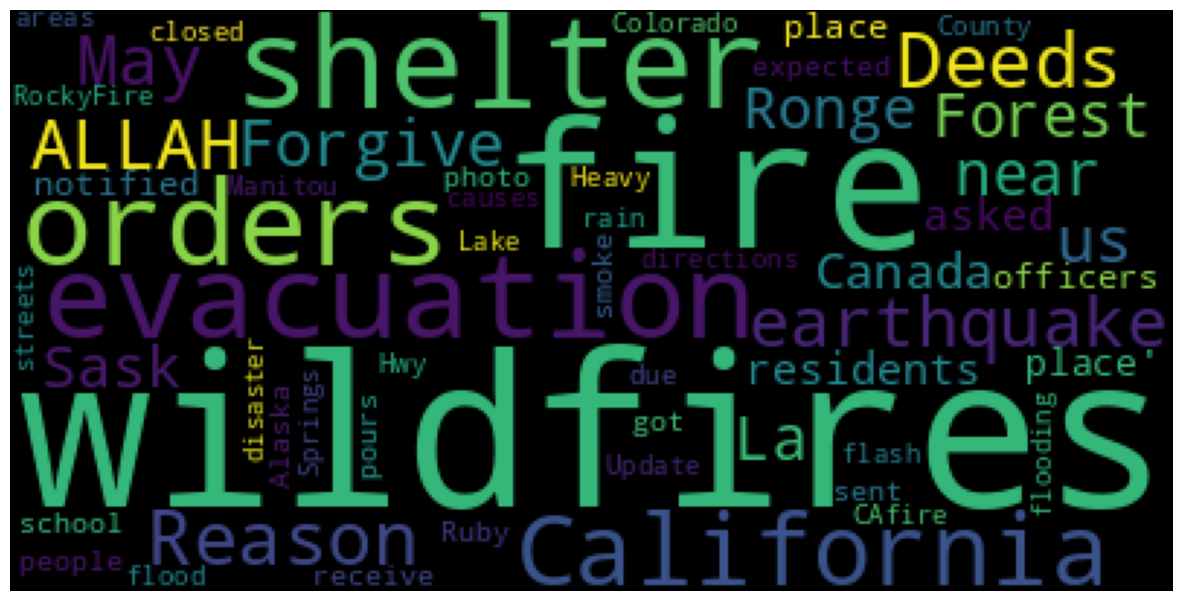

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(15, 10))
word_cloud = WordCloud(max_font_size=80).generate(" ".join(corpus_new[:100]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
plt.savefig('Figures/wordsCloud2.png')

# Convert from text to vectors

In [31]:
count_vectorizer = feature_extraction.text.CountVectorizer()

In [32]:
count_vectorizer.fit(df__tweet_tr['text'])

CountVectorizer()

In [33]:
df__tweet_tr_embedded = count_vectorizer.transform(df__tweet_tr['text'])
# df__tweet_te_embedded = count_vectorizer.transform(df__tweet_te['text'])

# Logistic Regression for tweets classification

In [34]:
X = df__tweet_tr["text"]
y = df__tweet_tr["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

# X_test = df__tweet_te["text"]

In [35]:
X_train_embedded = count_vectorizer.transform(X_train)
X_val_embedded = count_vectorizer.transform(X_val)

In [36]:
logit = LogisticRegression()
logit.fit(X_train_embedded, y_train)


LogisticRegression()

In [37]:
logit.score(X_train_embedded, y_train)


0.9666666666666667

In [38]:
logit.score(X_val_embedded, y_val)


0.8023637557452397

Displaying the confusion matrix for Logistic regression

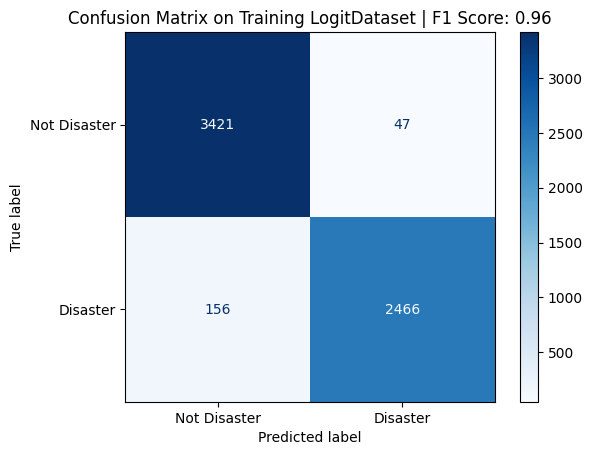

In [39]:
y_pred_train = logit.predict(X_train_embedded)

dgetConfusionMatrix(y_train, y_pred_train, "Training Logit","LogisticRegression")

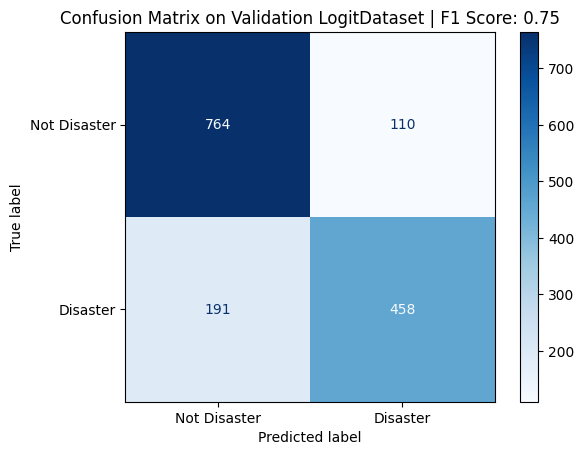

In [40]:
y_pred_val = logit.predict(X_val_embedded)

dgetConfusionMatrix(y_val, y_pred_val, "Validation Logit","LogisticRegression")

# Finetuning the DistilBERT for Tweets analysis

In [41]:
!pip install tensorflow-text

In [42]:
import tensorflow as tf
import tensorflow_text as text
import keras_nlp

In [43]:

preset = "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="tweets_preprocessor"
                                                                  )


classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

100%|██████████| 580/580 [00:00<00:00, 232kB/s]
100%|██████████| 226k/226k [00:00<00:00, 693kB/s]
100%|██████████| 515/515 [00:00<00:00, 319kB/s]
100%|██████████| 253M/253M [00:08<00:00, 30.5MB/s]


Preprocessor: "tweets_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=15,
                         epochs=4,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 144s 125ms/step - accuracy: 0.7379 - loss: 0.5364 - val_accuracy: 0.8385 - val_loss: 0.3983
Epoch 2/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.8465 - loss: 0.3632 - val_accuracy: 0.8398 - val_loss: 0.3939
Epoch 3/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 53s 129ms/step - accuracy: 0.8796 - loss: 0.3020 - val_accuracy: 0.8221 - val_loss: 0.4410
Epoch 4/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.9119 - loss: 0.2393 - val_accuracy: 0.8083 - val_loss: 0.4848


In [45]:
history.history

{'accuracy': [0.7889983654022217,
  0.8527093529701233,
  0.8822659850120544,
  0.9128078818321228],
 'loss': [0.46621641516685486,
  0.3566587567329407,
  0.29773786664009094,
  0.24240563809871674],
 'val_accuracy': [0.8384767174720764,
  0.839789867401123,
  0.8220617175102234,
  0.8082731366157532],
 'val_loss': [0.39828938245773315,
  0.39391449093818665,
  0.4410149157047272,
  0.48475030064582825]}

In [46]:

def plots_distilbert(history,fig_name):
  # Plotting training history
  plt.figure(figsize=(10, 5))

  # Plot training & validation accuracy values
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss', marker='o')
  plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
  plt.savefig('Figures/'+fig_name+'.png')

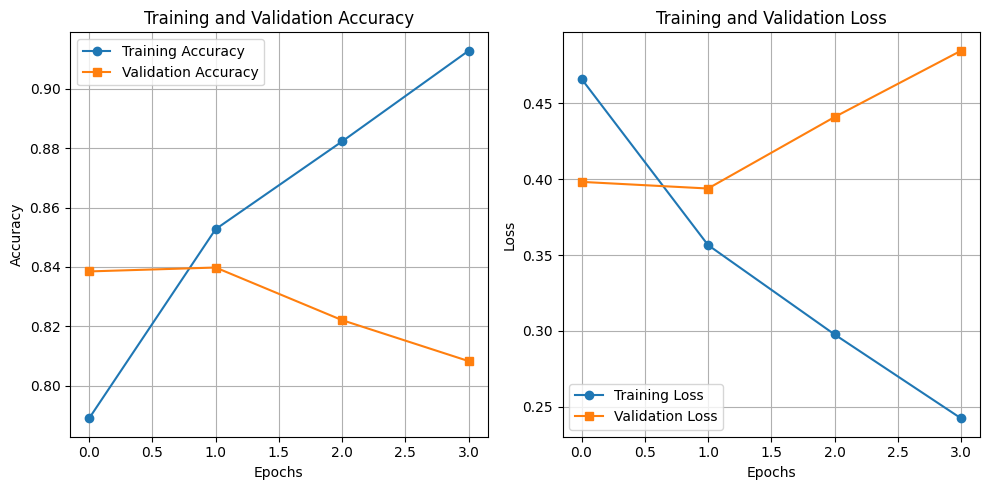

<Figure size 640x480 with 0 Axes>

In [47]:
plots_distilbert(history,"noautotune") #without autotune

191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step


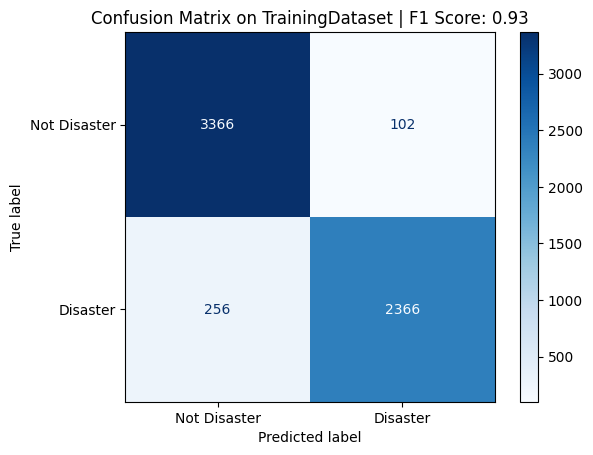

In [48]:
y_pred_train = classifier.predict(X_train)

dgetConfusionMatrix(y_train, y_pred_train, "Training","Distilbert")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step


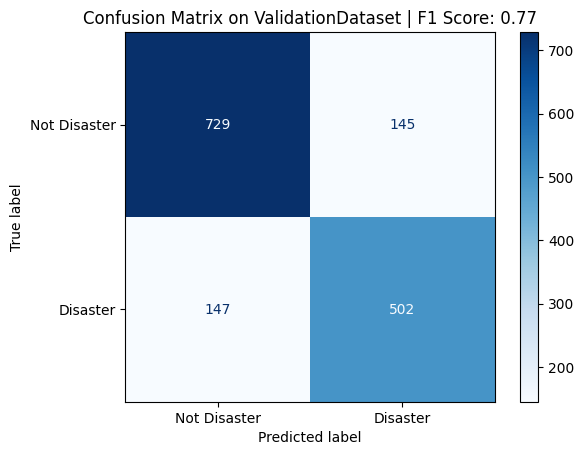

In [49]:
y_pred_val = classifier.predict(X_val)

dgetConfusionMatrix(y_val, y_pred_val, "Validation","Distilbert")

In [50]:

# Apply preprocessing operations to the datasets
preset = "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="tweets_preprocessor_autotune"
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Apply AUTOTUNE to optimize data loading and processing
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Now train the classifier using the prepared datasets
history_autotune = classifier.fit(
    x=train_dataset,
    # batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 151s 324ms/step - accuracy: 0.9340 - loss: 0.2011 - val_accuracy: 0.8227 - val_loss: 0.4880
Epoch 2/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 54s 177ms/step - accuracy: 0.9467 - loss: 0.1619 - val_accuracy: 0.8207 - val_loss: 0.5651
Epoch 3/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.9547 - loss: 0.1308 - val_accuracy: 0.8135 - val_loss: 0.6362
Epoch 4/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.9649 - loss: 0.1087 - val_accuracy: 0.7912 - val_loss: 0.8028
Epoch 5/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 56s 182ms/step - accuracy: 0.9717 - loss: 0.0820 - val_accuracy: 0.8155 - val_loss: 0.7494
Epoch 6/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 90s 296ms/step - accuracy: 0.9748 - loss: 0.0708 - val_accuracy: 0.8050 - val_loss: 0.8431
Epoch 7/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 56s 182ms/step - accuracy: 0.9775 - loss: 0.0616 - val_accuracy: 0.8122 - val_loss: 0.8406


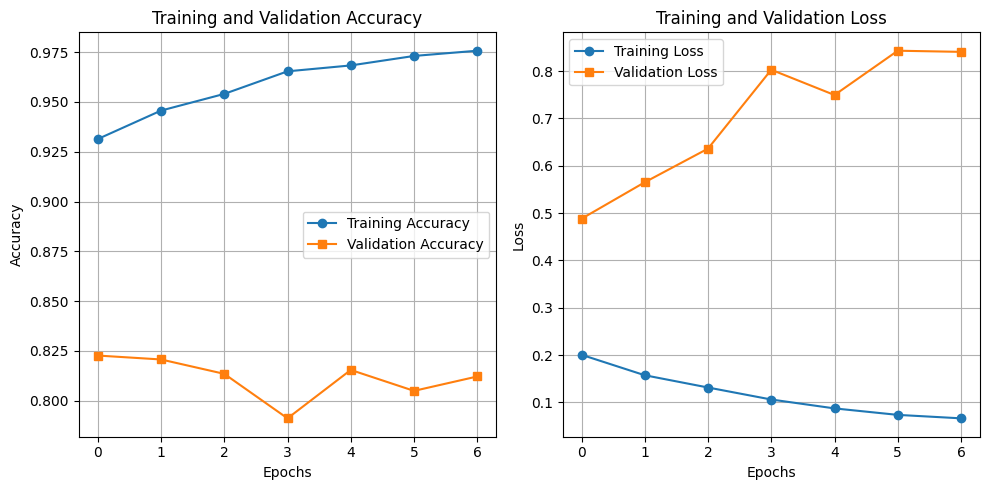

<Figure size 640x480 with 0 Axes>

In [51]:
plots_distilbert(history_autotune,"autotune") #with autotune

191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


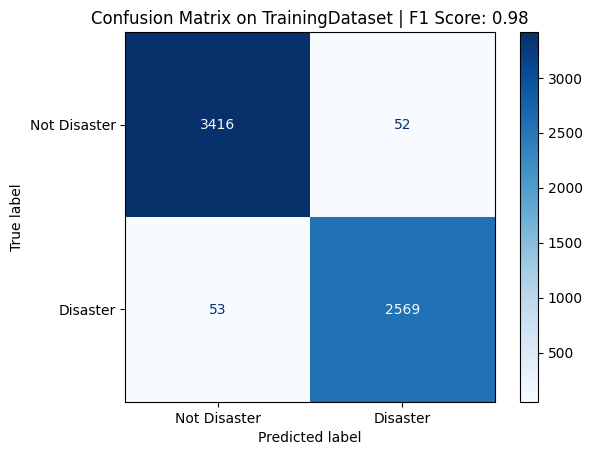

In [52]:
y_pred_train = classifier.predict(X_train)

dgetConfusionMatrix(y_train, y_pred_train, "Training","Distilbert_autotune")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


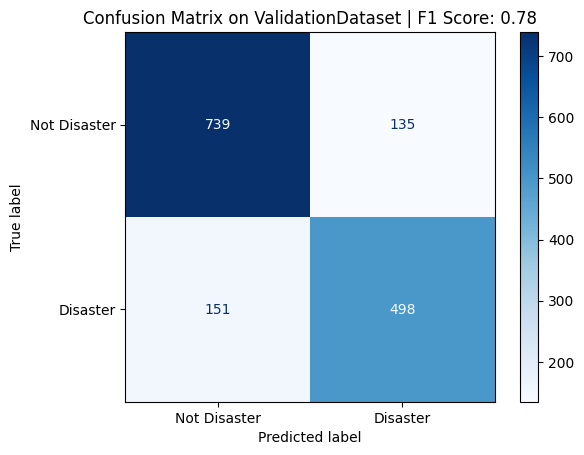

In [53]:
y_pred_val = classifier.predict(X_val)

dgetConfusionMatrix(y_val, y_pred_val, "Validation","Distilbert_autotune")

In [ ]:
# downloading figures
%cd /content/
!zip -r Figures.zip Figures/
from google.colab import files

files.download('Figures.zip')


In [55]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameters for grid search
param_grid = {
    'sequence_length': [128, 160, 192],
    'buffer_size': [1000, 2000],
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_params = None
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"])

for params in param_combinations:
    print("Training with hyperparameters:", params)

    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
        preset,
        sequence_length=params['sequence_length'],
        name="tweets_preprocessor_autotune"
    )

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    train_dataset = train_dataset.shuffle(buffer_size=params['buffer_size']).batch(params['batch_size']).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(params['batch_size']).prefetch(tf.data.AUTOTUNE)


    history_gridsearch = classifier.fit(
        x=train_dataset,
        epochs=params['epochs'],
        validation_data=val_dataset
    )

    # Evaluate the model on the validation set
    accuracy = classifier.evaluate(val_dataset)[1]

    print("Validation accuracy:", accuracy)

    # Update best hyperparameters if the current combination performs better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best validation accuracy:", best_accuracy)
print("Best hyperparameters:", best_params)


Training with hyperparameters: {'batch_size': 16, 'buffer_size': 1000, 'epochs': 5, 'sequence_length': 128}
Epoch 1/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 158s 205ms/step - accuracy: 0.6995 - loss: 0.5518 - val_accuracy: 0.8372 - val_loss: 0.3970
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - accuracy: 0.8419 - loss: 0.3734 - val_accuracy: 0.8345 - val_loss: 0.3974
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.8709 - loss: 0.3122 - val_accuracy: 0.8306 - val_loss: 0.4187
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.9012 - loss: 0.2628 - val_accuracy: 0.8148 - val_loss: 0.4945
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9217 - loss: 0.2098 - val_accuracy: 0.8260 - val_loss: 0.5132
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8182 - loss: 0.5312
Validation accuracy: 0.8260012865066528
Training with hyperparameters: {'batch_size': 16, 'buffer_size': 1000, 'epochs': 5, 'sequence_length': 160}
Epoch 1/5
381/381 ━━━